## Our First Convolutional Neural Network

    - How to learn the values of the kernels? By SGD
    - The model will learn the features that are useful for classification via SGD
    - When we use convolutions instead of (or in addition to) regular linear layers, we create a convolutional neural network (CNN).

### Creating the CNN

In [19]:
from fastai.vision.all import *

In [2]:
# The basic NN (with regular linear layers) is like this:
simple_net = sequential(
    nn.Linear(28*28, 30), # (28*28 --> 30)
    nn.ReLU(), # 30 -> 30
    nn.Linear(30,1) # 30 -> 1
)

simple_net

Sequential(
  (0): Linear(in_features=784, out_features=30, bias=True)
  (1): ReLU()
  (2): Linear(in_features=30, out_features=1, bias=True)
)

In [6]:
# Now we want to create a similar archcitecture to this linear model but using *convlution*
broken_cnn = sequential(
    nn.Conv2d(1, 30, kernel_size=3, padding=1), # (B,1,H,W) → (B,30,H,W)
    # input channel 1(black&white) --> output channel 30 (# of hidden feature map)
    # #params = 30(filters) x 1(in_ch) x 3 x 3 = 270 
    nn.ReLU(), # Adding non-linearity to hidden feture map
    nn.Conv2d(30,1, kernel_size=3, padding=1) # # (B,30,H,W) → (B,1,H,W)
    # hidden channel 30 --> output channel 1
    # returns [batch, 1, H, W] (logit map)
)

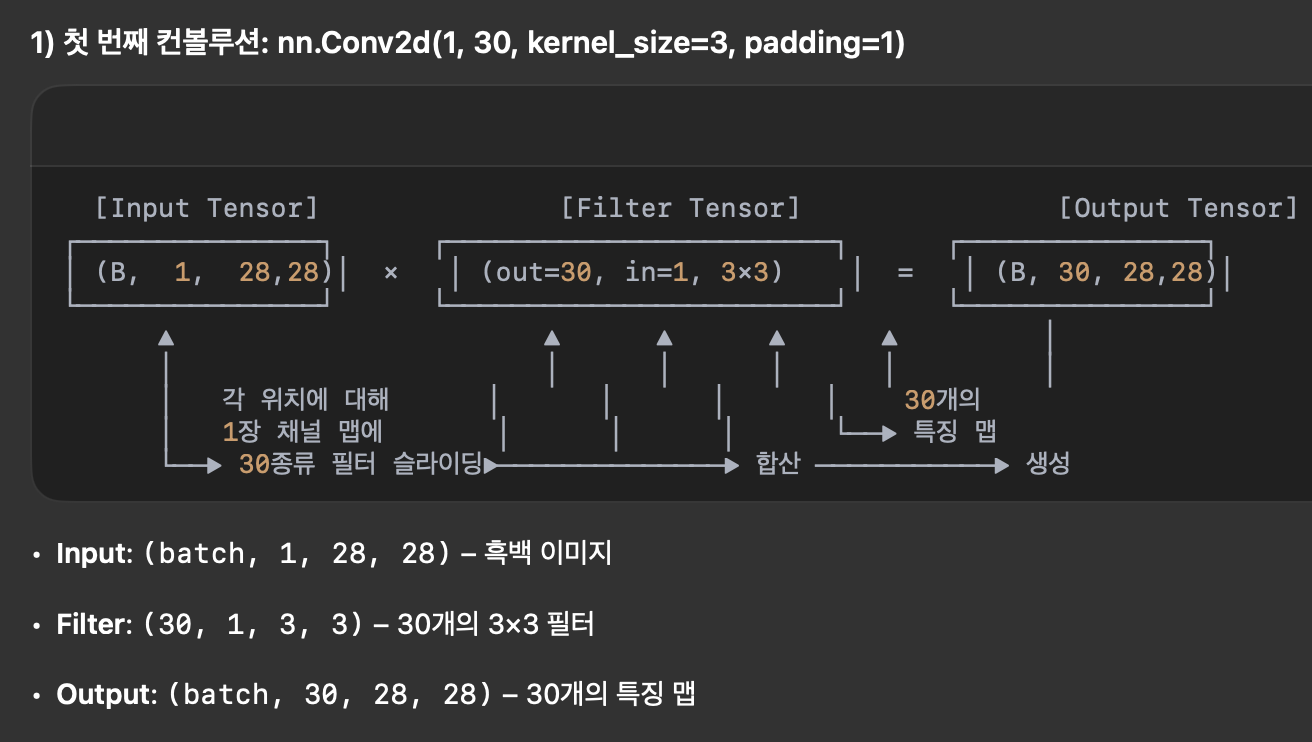
--> [1 -> 30] channel
--> 30가지 필터로 다양한 local features 뽑아냄, 결과를 30장 map으로 저장 
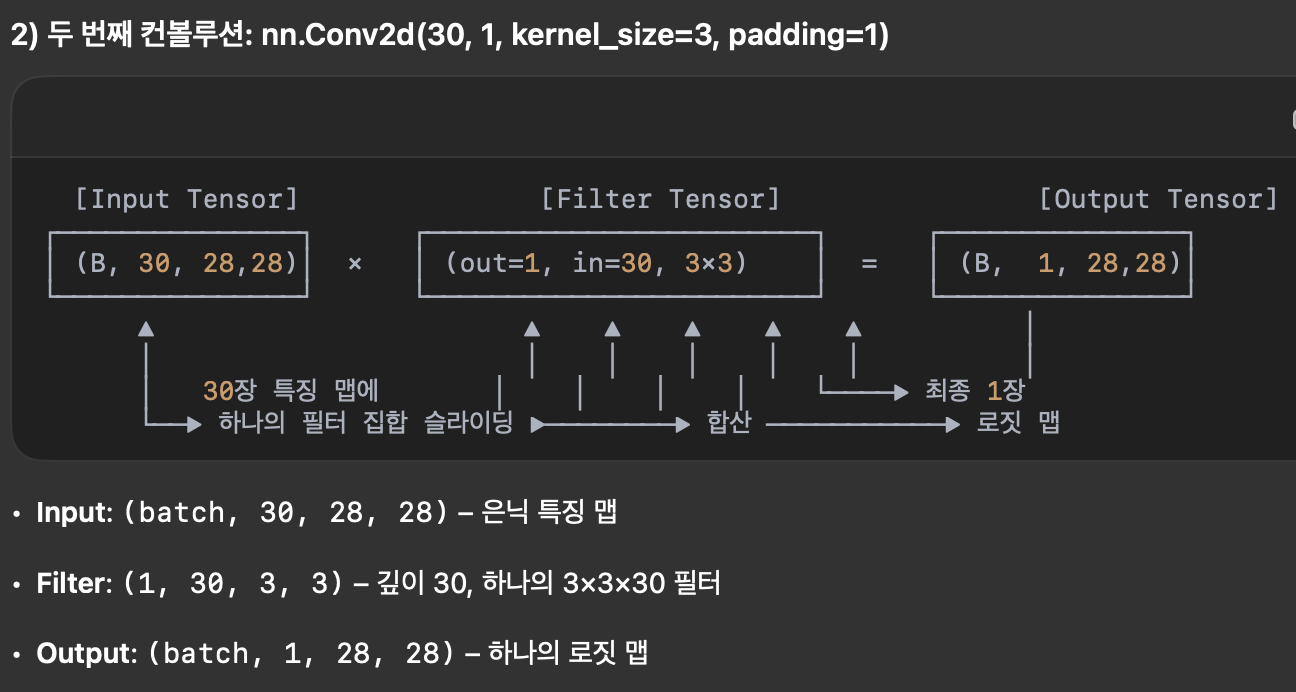
--> [30 -> 1] channel
--> 앞에서 뽑아낸 30장 map을 하나의 필터로 합산, 최종 logit map (pixel단위 scalar score) 출력

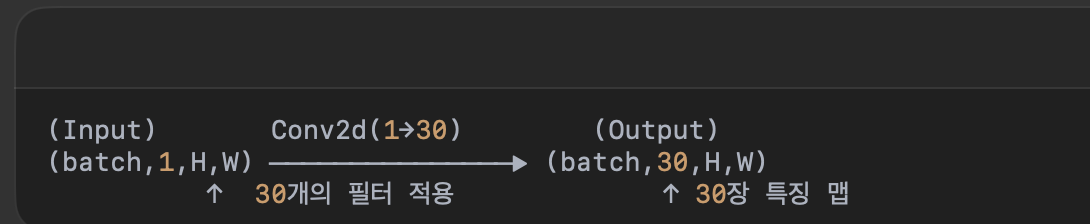

## Why `Conv2d`’s Weights Depend Only on Channels & Kernel Size

1. **Shared Weights Across Spatial Positions**  
   - A convolutional layer applies the **same** small filter (kernel) at **every** spatial location.  
   - You don’t need a separate weight for each pixel in the image—only one copy of the filter.

2. **Filter Shape: `[out_channels, in_channels, kH, kW]`**  
   - **`in_channels`**: number of input feature maps the filter looks at  
   - **`out_channels`**: number of distinct filters (each produces one output map)  
   - **`kH, kW`**: height and width of the spatial kernel (e.g. 3×3)  

3. **Parameter Count Formula**  

$$
\text{number of parameters}
\;=\;
\underbrace{\text{out\_channels}}_{\substack{\text{number of}\\\text{filters}}}
\;\times\;
\underbrace{\text{in\_channels}}_{\text{depth of each filter}}
\;\times\;
\underbrace{kH \times kW}_{\text{spatial size of filter}}
$$
   
   | Term             | Meaning                                                      |
   |------------------|--------------------------------------------------------------|
   | `out_channels`   | Number of distinct filters (i.e. number of output maps)     |
   | `in_channels`    | Number of input maps each filter spans                      |
   | `kH × kW`        | Spatial dimensions of each filter (e.g. 3×3 = 9 weights)    |

4. **Example**  
   - A `Conv2d(1, 30, kernel_size=3)` layer on a grayscale image:  
     $
       \#params = 30 \times 1 \times (3 \times 3) = 270
     $
   - A `Conv2d(30, 100, kernel_size=5)` layer on a 30-channel feature map:  
     $
       \#params = 100 \times 30 \times (5 \times 5) = 75{,}000
     $

---

### Key Takeaway

- **Convolutional layers** are incredibly parameter-efficient because they **share** a small filter across all spatial locations and only need to know:
  1. **How many filters** to learn (`out_channels`),  
  2. **How deep** each filter is (`in_channels`), and  
  3. **How big** each filter is (`kernel_size × kernel_size`).

In [8]:
from torch.utils.data import DataLoader, TensorDataset

# example random dataset (100 black and white 28*28 images)
dummy_images = torch.rand(100, 1, 28,28)
dummy_labels = torch.zeros(100) # all 0 since we are not going to use labels 

dataset = TensorDataset(dummy_images, dummy_labels)
dl=DataLoader(dataset, batch_size = 64)

xb, yb = next(iter(dl))
print(xb.shape)


torch.Size([64, 1, 28, 28])


In [9]:
out = broken_cnn(xb)
print(out.shape)

torch.Size([64, 1, 28, 28])


In [22]:
def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding= ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

In [23]:
# Build a simple CNN
simple_cnn = sequential(
    conv(1,4), # 28×28 → 14×14
    conv(4,8),  # 14×14 → 7×7
    conv(8,16),  # 7×7   → 4×4
    conv(16,32),  # 4×4   → 2×2
    conv(32,2, act=False), # 2×2 → 1×1
    Flatten() # (batch, 2,1,1) → (batch,2) (where 2= #channel)

)

In [24]:
simple_cnn(xb).shape

torch.Size([64, 2])

### learn = Learner(dls, simple_cnn, loss_func=F.cross_entropy, metrics=accuracy)
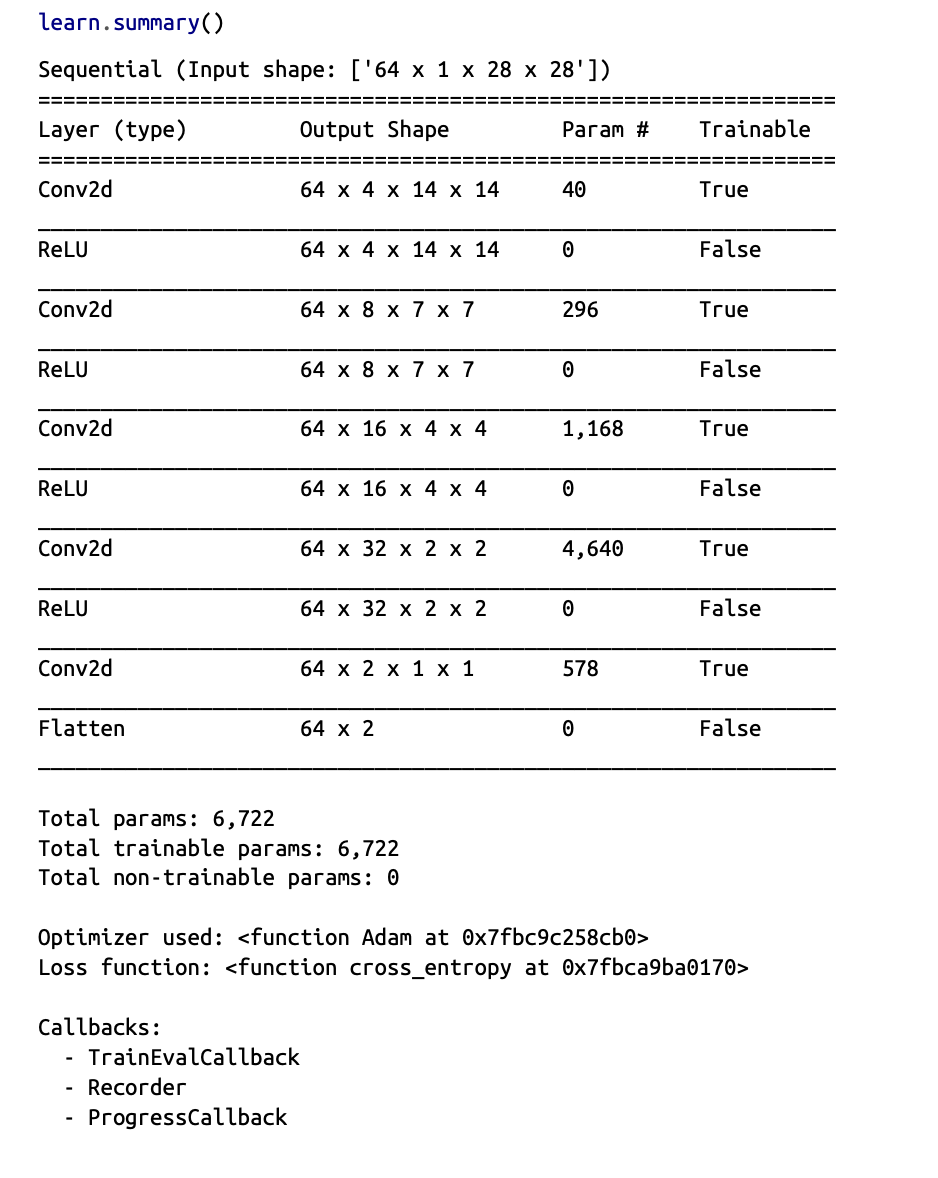

### Understanding Convolution Arithmetic 

##### Key Insights: Balancing Downsampling & Channel Expansion in CNNs

1. **Downsample ↔ Channel Increase**  
   - Using `stride=2` halves spatial resolution (H,W) each layer.  
   - Simultaneously **increasing** `out_channels` keeps total compute (C×H×W) roughly constant.

2. **Too Much Downsampling Alone**  
   - Fixing channels but only downsampling causes compute to **shrink** rapidly with depth.  
   - Deep layers would have insufficient capacity to learn high-level patterns.

3. **Too Much Channel Growth Alone**  
   - Fixing resolution but only increasing channels leads to **explosive** memory and FLOPs.  
   - Quickly becomes infeasible on practical hardware.

4. **Why This Balance Matters**  
   - Early layers detect simple, local features; deep layers capture complex, semantic features.  
   - By downsampling and expanding channels together, you preserve model capacity **efficiently** and **scalably**.

> **Bottom Line**:  
> “Downsample by 2 → halve H,W; increase channels → maintain C×H×W”  
> is a widely used pattern for creating **efficient**, **expressive** CNN architectures.  

## Receptive Fields

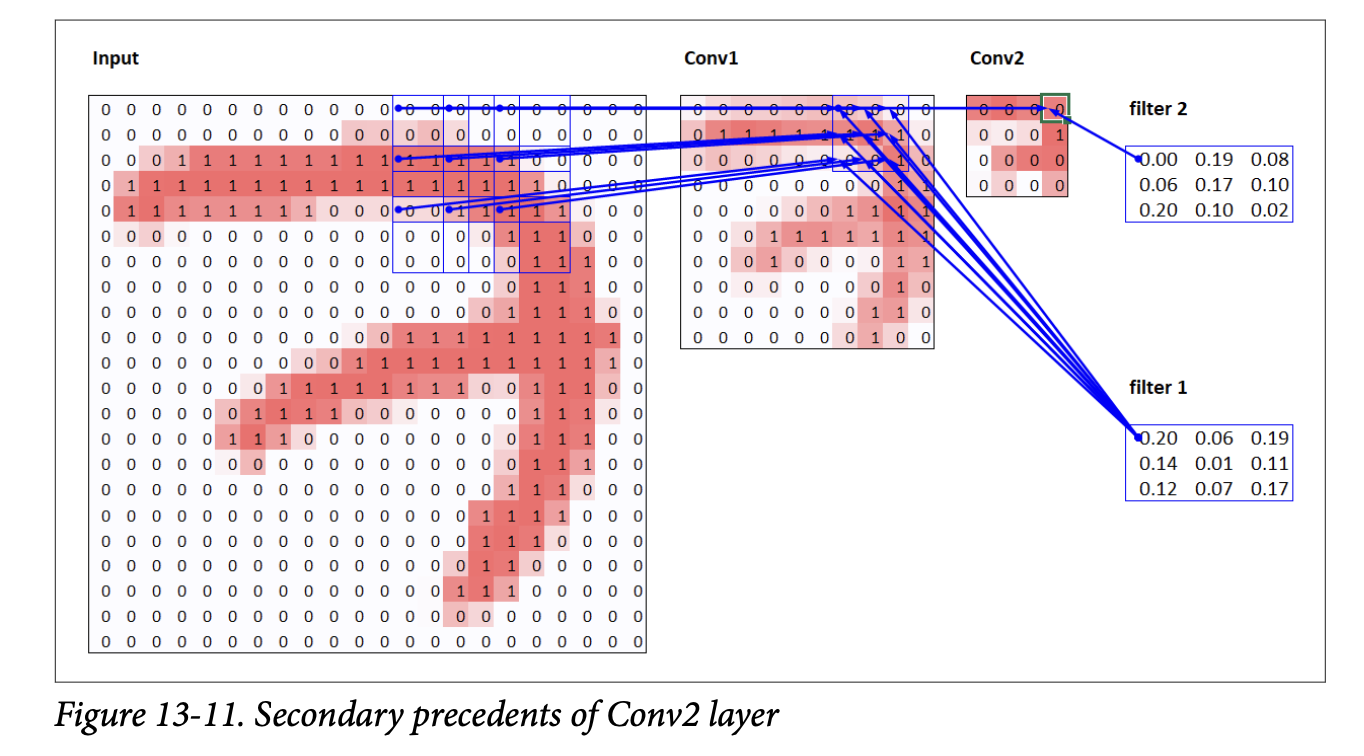
#### What it shows:
        - Each cell in Conv2 is computed from a 3×3 patch in Conv1 (due to k=3).
        - Each Conv1 cell, in turn, comes from a 3×3 patch in the input image.
        - Combining these, a single Conv2 cell has a 7×7 receptive field in the input.
#### Why it matters:
        - As we go deeper (especially with stride > 1), each activation covers a larger area of the input.
        - Larger receptive fields capture more complex, semantic features (e.g., object parts).
        - Downsampling reduces spatial resolution; increasing channels balances representational capacity.
        - Understanding receptive fields is key for network design, feature map interpretation, and debugging.